In [225]:
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.preprocessing as pre
from transforming import WithSelected, DFPowerTransform, Apply, Drop

from sklearn.metrics import f1_score, roc_auc_score

__loading__

In [226]:
source = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

X_source = source.drop(columns=['id', 'target'])
y = source.target

In [3]:
# class MeanBy(BaseEstimator, TransformerMixin):
#     def __init__(self, by=None):
#         self.__mean = None
#         self.__basic_mean = None
#         self.__by = by
    
#     def fit(self, X, y=None):
#         df = X.copy()
#         self.__mean = df.groupby(self.__by).mean()
#         self.__basic_mean = df.mean()
#         return self

#     def transform(self, X, y=None):
#         X = X.copy()
#         if self.__by in X.columns:
#             return X.merge(self.__mean, on=self.__by, suffixes=('', '_mean'))
#         else:
#             exists = self.__basic_mean[self.__basic_mean.index.isin(X.columns)]
#             X[[f'{f}_mean' for f in exists.index]] = exists
#             return X

__preprocessing__

In [4]:
# pipe = make_pipeline(
#     WithSelected(['gravity'], suffix='bins')(
#         pre.KBinsDiscretizer(5, encode='ordinal', strategy='quantile')
#     ),
#     WithSelected(['ph'], suffix='bins')(
#         pre.KBinsDiscretizer(10, encode='ordinal', strategy='quantile')
#     ),
#     WithSelected(['osmo'], suffix='bins')(
#         pre.KBinsDiscretizer(5, encode='ordinal', strategy='quantile')
#     ),
#     WithSelected(['cond'], suffix='bins')(
#         pre.KBinsDiscretizer(7, encode='ordinal', strategy='quantile')
#     ),
#     WithSelected(['urea'], suffix='bins')(
#         pre.KBinsDiscretizer(7, encode='ordinal', strategy='quantile')
#     ),
#     WithSelected(['calc'], suffix='bins')(
#         pre.KBinsDiscretizer(5, encode='ordinal', strategy='quantile')
#     )
# )

In [303]:
original = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
pipe = make_pipeline(
    WithSelected(original, 'pow')(
        DFPowerTransform()
    ),
    WithSelected(['gravity', 'gravity_pow'], suffix='bins')(
        pre.KBinsDiscretizer(7, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['ph', 'ph_pow'], suffix='bins')(
        pre.KBinsDiscretizer(7, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['osmo', 'osmo_pow'], suffix='bins')(
        pre.KBinsDiscretizer(10, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['cond', 'cond_pow'], suffix='bins')(
        pre.KBinsDiscretizer(5, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['urea', 'urea_pow'], suffix='bins')(
        pre.KBinsDiscretizer(10, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['calc', 'calc_pow'], suffix='bins')(
        pre.KBinsDiscretizer(5, encode='ordinal', strategy='quantile')
    ),

    # Apply(
    #     estimator=KNeighborsClassifier(7, leaf_size=30, n_jobs=-1),
    #     to='neighbours'
    # ),
    Apply(
        estimator=LinearDiscriminantAnalysis(solver='lsqr'),
        locpipe=pre.Normalizer(),
        # on=lambda columns: [col for col in columns if 'pow' in col],
        to='lda'
    ),
    Apply(
        estimator=KNeighborsClassifier(7, leaf_size=30, n_jobs=-1),
        to='neighbours'
    ),
    Apply(
        estimator=IsolationForest(n_estimators=20, max_samples='auto', warm_start=True, bootstrap=True, n_jobs=-1, random_state=17),
        locpipe=pre.Normalizer(),
        to='isolation'
    ),
    # Drop(original),
    # Drop([col for col in X.columns if 'calc' in col])

)

In [304]:
# X = source.drop(columns=['id', 'target'])     # basic dataframe
X = pipe.fit_transform(X_source, y)
X.head()

,gravity,ph,osmo,cond,urea,calc,gravity_pow,ph_pow,osmo_pow,cond_pow,...,osmo_pow_bins,cond_bins,cond_pow_bins,urea_bins,urea_pow_bins,calc_bins,calc_pow_bins,lda,neighbours,isolation
0,1.013,6.19,443,14.8,124,1.45,-0.715963,0.561764,-0.871068,-0.896527,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1
1,1.025,5.40,703,23.6,394,4.18,1.068414,-0.925220,0.264756,0.271176,...,5.0,2.0,2.0,7.0,7.0,3.0,3.0,1,1,1
2,1.009,6.13,371,24.5,159,9.04,-1.390925,0.472669,-1.214939,0.393761,...,1.0,3.0,3.0,2.0,2.0,4.0,4.0,1,0,-1
3,1.021,4.91,442,20.8,398,6.63,0.511126,-2.325350,-0.875736,-0.106754,...,2.0,2.0,2.0,8.0,8.0,3.0,3.0,1,1,-1
4,1.021,5.53,874,17.8,385,2.21,0.511126,-0.626023,0.948906,-0.505359,...,8.0,1.0,1.0,7.0,7.0,1.0,1.0,0,1,1


__fit & validate__

In [305]:
def checkup(estimator, X, folds=7):
    metrics = []
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=19)
    for f, (train, valid) in enumerate(kf.split(X, y)):
        estimator.fit(X.loc[train], y[train])
        
        pt = estimator.predict_proba(X.loc[train]).T[1]
        pv = estimator.predict_proba(X.loc[valid]).T[1]

        auc_train = roc_auc_score(y[train], pt)
        auc_valid = roc_auc_score(y[valid], pv)
        f1_train = f1_score(y[train], pt > 0.5)
        f1_valid = f1_score(y[valid], pv > 0.5)
        metrics.append((auc_train, f1_train, auc_valid, f1_valid))
        print(f'Fold: {f}; TRAIN ROC AUC={auc_train:.5f}; TRAIN f1={f1_train:.5f} | VALID ROC AUC={auc_valid:.5f}; VALID f1={f1_valid:.5f}')
    means = np.mean(metrics, axis=0)
    print(f'MEAN: TRAIN ROC AUC={means[0]:.5f}; TRAIN f1={means[1]:.5f} | VALID ROC AUC={means[2]:.5f}; VALID f1={means[3]:.5f}')
    return estimator

In [306]:
checkup(KNeighborsClassifier(3, leaf_size=17, n_jobs=-1), X, folds=7);

Fold: 0; TRAIN ROC AUC=0.87964; TRAIN f1=0.76923 | VALID ROC AUC=0.62121; VALID f1=0.55556
Fold: 1; TRAIN ROC AUC=0.87326; TRAIN f1=0.75585 | VALID ROC AUC=0.66375; VALID f1=0.56522
Fold: 2; TRAIN ROC AUC=0.88627; TRAIN f1=0.77124 | VALID ROC AUC=0.55711; VALID f1=0.40000
Fold: 3; TRAIN ROC AUC=0.85478; TRAIN f1=0.74684 | VALID ROC AUC=0.62821; VALID f1=0.57143
Fold: 4; TRAIN ROC AUC=0.87856; TRAIN f1=0.77419 | VALID ROC AUC=0.66958; VALID f1=0.61224
Fold: 5; TRAIN ROC AUC=0.87689; TRAIN f1=0.76471 | VALID ROC AUC=0.59732; VALID f1=0.42553
Fold: 6; TRAIN ROC AUC=0.86553; TRAIN f1=0.74834 | VALID ROC AUC=0.63310; VALID f1=0.52830
MEAN: TRAIN ROC AUC=0.87356; TRAIN f1=0.76149 | VALID ROC AUC=0.62433; VALID f1=0.52261


Fold: 0; TRAIN ROC AUC=0.90638; TRAIN f1=0.81029 | VALID ROC AUC=0.76487; VALID f1=0.61538
Fold: 1; TRAIN ROC AUC=0.89777; TRAIN f1=0.79221 | VALID ROC AUC=0.82984; VALID f1=0.77551
Fold: 2; TRAIN ROC AUC=0.91303; TRAIN f1=0.81646 | VALID ROC AUC=0.76399; VALID f1=0.66667
Fold: 3; TRAIN ROC AUC=0.89803; TRAIN f1=0.78344 | VALID ROC AUC=0.87529; VALID f1=0.79245
Fold: 4; TRAIN ROC AUC=0.90816; TRAIN f1=0.79503 | VALID ROC AUC=0.81469; VALID f1=0.67925
Fold: 5; TRAIN ROC AUC=0.90381; TRAIN f1=0.77524 | VALID ROC AUC=0.85315; VALID f1=0.75862
Fold: 6; TRAIN ROC AUC=0.90134; TRAIN f1=0.78571 | VALID ROC AUC=0.84201; VALID f1=0.69388
MEAN: TRAIN ROC AUC=0.90407; TRAIN f1=0.79405 | VALID ROC AUC=0.82055; VALID f1=0.71168


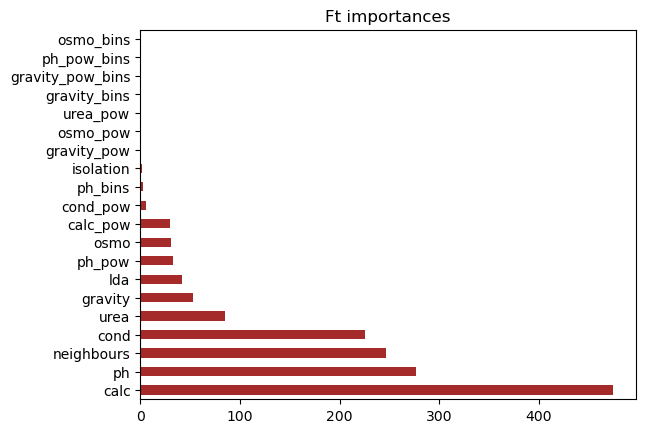

In [307]:
# FIT LGBM
est = checkup(LGBMClassifier(n_estimators=250, learning_rate=0.01, max_depth=3, n_jobs=-1, random_state=11), X, folds=7);
feat_importances = pd.Series(est.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='brown');

Fold: 0; TRAIN ROC AUC=0.88370; TRAIN f1=0.78065 | VALID ROC AUC=0.79910; VALID f1=0.76364
Fold: 1; TRAIN ROC AUC=0.87162; TRAIN f1=0.76282 | VALID ROC AUC=0.82284; VALID f1=0.76000
Fold: 2; TRAIN ROC AUC=0.88627; TRAIN f1=0.78882 | VALID ROC AUC=0.77389; VALID f1=0.66667
Fold: 3; TRAIN ROC AUC=0.87020; TRAIN f1=0.77316 | VALID ROC AUC=0.83566; VALID f1=0.79245
Fold: 4; TRAIN ROC AUC=0.87673; TRAIN f1=0.76161 | VALID ROC AUC=0.80186; VALID f1=0.69231
Fold: 5; TRAIN ROC AUC=0.87981; TRAIN f1=0.77670 | VALID ROC AUC=0.83800; VALID f1=0.75862
Fold: 6; TRAIN ROC AUC=0.88098; TRAIN f1=0.76375 | VALID ROC AUC=0.84606; VALID f1=0.60465
MEAN: TRAIN ROC AUC=0.87847; TRAIN f1=0.77250 | VALID ROC AUC=0.81678; VALID f1=0.71976


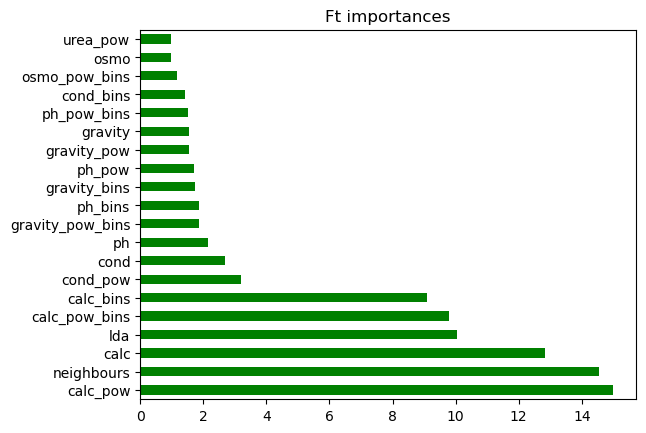

In [310]:
# FIT CatBoost
est = checkup(CatBoostClassifier(iterations=250, learning_rate=0.01, depth=3, random_state=11, verbose=False, allow_writing_files=False), X, folds=7);
feat_importances = pd.Series(est.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='green');

Fold: 0; TRAIN ROC AUC=0.91527; TRAIN f1=0.81672 | VALID ROC AUC=0.78451; VALID f1=0.75862
Fold: 1; TRAIN ROC AUC=0.90861; TRAIN f1=0.79208 | VALID ROC AUC=0.83800; VALID f1=0.77551
Fold: 2; TRAIN ROC AUC=0.91756; TRAIN f1=0.79874 | VALID ROC AUC=0.79254; VALID f1=0.67925
Fold: 3; TRAIN ROC AUC=0.90643; TRAIN f1=0.80374 | VALID ROC AUC=0.86247; VALID f1=0.74510
Fold: 4; TRAIN ROC AUC=0.91104; TRAIN f1=0.81250 | VALID ROC AUC=0.80828; VALID f1=0.73077
Fold: 5; TRAIN ROC AUC=0.91139; TRAIN f1=0.78710 | VALID ROC AUC=0.85082; VALID f1=0.75000
Fold: 6; TRAIN ROC AUC=0.91450; TRAIN f1=0.80000 | VALID ROC AUC=0.83449; VALID f1=0.63830
MEAN: TRAIN ROC AUC=0.91211; TRAIN f1=0.80155 | VALID ROC AUC=0.82444; VALID f1=0.72536


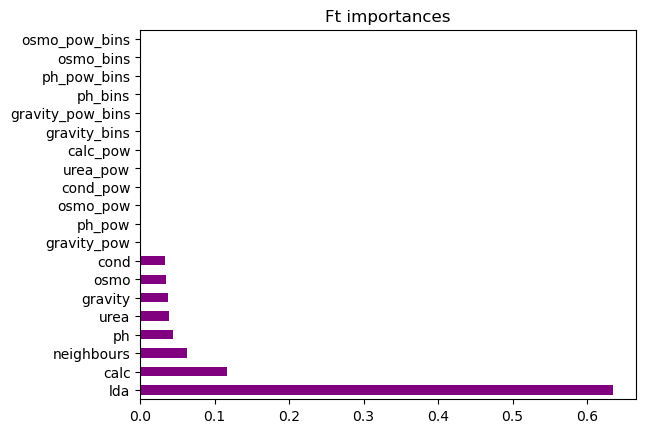

In [309]:
# FIT XGBoost
est = checkup(XGBClassifier(n_estimators=250, learning_rate=0.01, max_depth=3, random_state=23), X, folds=7);
feat_importances = pd.Series(est.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='purple');

__features selection__

In [100]:
# feat_importances = pd.Series(estimator.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='green');

In [ ]:
# TODO

In [41]:
# # make shadow features by randomly permuting each column of X
# np.random.seed(42)
# X_shadow = X.apply(np.random.permutation)
# X_shadow.columns = ['shadow_' + feat for feat in X.columns]
# X_boruta = pd.concat([X, X_shadow], axis = 1)

In [46]:
# metrics = []
# estimator = LGBMClassifier(n_jobs=-1, random_state=11)
# kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=19)
# for f, (train, valid) in enumerate(kf.split(X_boruta, y)):
#     estimator.fit(X_boruta.loc[train], y[train])
#     p = estimator.predict(X_boruta.loc[valid])
#     auc = roc_auc_score(p, y[valid])
#     f1 = f1_score(p, y[valid])
#     metrics.append((auc, f1))
#     print(f'Fold: {f}; ROC AUC={auc:.5f}; f1={f1:.5f}')
# means = np.mean(metrics, axis=1)
# print(f'MEAN: ROC AUC={means[0]:.5f}; f1={means[1]:.5f}')

In [47]:
# feat_imp_X = estimator.feature_importances_[:len(X.columns)]
# feat_imp_shadow = estimator.feature_importances_[len(X.columns):]
# hits = feat_imp_X > feat_imp_shadow.max()
# hits

In [ ]:
# PREDICT
submission = pd.read_csv('data/sample_submission.csv')
submission.target = estimator.predict_proba(X_test).T[1]
submission.to_csv(f'submission_{dt.datetime.now().replace(microsecond=0)}.csv', index=False)

In [ ]:
#